<a href="https://colab.research.google.com/github/heidarimohsen92/LDNet/blob/main/Brain_tumor_LDNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import sys
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  
import tensorflow.keras.backend as K
from skimage.transform import resize
from skimage.io import imread, imshow, imread_collection, concatenate_images
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Concatenate, Activation, MaxPool2D, UpSampling2D, Input, Dropout
from tensorflow.keras.layers import Activation, BatchNormalization, Lambda, Add, Multiply, add

### Download and Load the [`brain-tumor-segmentation`](https://www.kaggle.com/datasets/tinashri/brain-tumor-segmentation-datasets) dataset from kaggle

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tinashri/brain-tumor-segmentation-datasets
!unzip /content/brain-tumor-segmentation-datasets.zip

# !rm -rf brain-tumor-segmentation-datasets.zip

# Dataset Preprocessing

In [ ]:
# Create Lists of images and masks in Augmented paths
def label_data(fn): 
    return str(fn).replace("images", "masks")

data_dir = '/content/data/images'
img_path = sorted( [os.path.join(data_dir , i) for i in os.listdir(data_dir)] )
mask_path = [label_data(i) for i in img_path]

print("number of images is : {}".format(len(img_path)))
print("number of mask is : {} \n".format(len(mask_path)))
for input_path, target_path in zip(img_path[:10], mask_path[:10]):
    print(input_path, "|", target_path)

number of images is : 3064
number of mask is : 3064 

/content/data/images/1.png | /content/data/masks/1.png
/content/data/images/10.png | /content/data/masks/10.png
/content/data/images/100.png | /content/data/masks/100.png
/content/data/images/1000.png | /content/data/masks/1000.png
/content/data/images/1001.png | /content/data/masks/1001.png
/content/data/images/1002.png | /content/data/masks/1002.png
/content/data/images/1003.png | /content/data/masks/1003.png
/content/data/images/1004.png | /content/data/masks/1004.png
/content/data/images/1005.png | /content/data/masks/1005.png
/content/data/images/1006.png | /content/data/masks/1006.png


**Creating our image masks of dimension 256 x 256 (black images)**

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

X_data = np.zeros((len(img_path), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_data = np.zeros((len(mask_path), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
# Re-sizing our training images to 256 x 256
# Note sys.stdout prints info that can be cleared unlike print.
# Using TQDM allows us to create progress bars
sys.stdout.flush()

print('Getting and resizing training images ... ')
for n, img_dir in tqdm(enumerate(img_path), total=len(img_path)):
    img = imread(img_dir)
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)
    X_data[n] = img

# data mask
print('\nGetting and resizing test mask ... ')
for n, mask_dir in tqdm(enumerate(mask_path), total=len(mask_path)):
    mask = imread(mask_dir)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)
    Y_data[n] = mask

Getting and resizing training images ... 


100%|██████████| 3064/3064 [01:04<00:00, 47.44it/s]



Getting and resizing test mask ... 


100%|██████████| 3064/3064 [00:35<00:00, 85.11it/s]


## Split Data

In [ ]:
# Splitting the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.05, random_state=42)
print("train images shape:{}".format(X_train.shape), "|" , "train mask shape:{} \n".format(Y_train.shape))
print("test images shape:{}".format(X_test.shape), "|" , "test mask shape:{} \n".format(Y_test.shape))

train images shape:(2910, 256, 256, 3) | train mask shape:(2910, 256, 256, 1) 

test images shape:(154, 256, 256, 3) | test mask shape:(154, 256, 256, 1) 



### **DropBlock2D LDNet**

In [ ]:
# DropBlock: A regularization method for convolutional networks
# arXiv. https://arxiv.org/abs/1810.12890

def _bernoulli(shape, mean):
    return tf.nn.relu(tf.sign(mean - tf.random.uniform(shape, minval=0, maxval=1, dtype=tf.float32)))


class DropBlock2D(tf.keras.layers.Layer):
    def __init__(self, keep_prob, block_size, scale=True,name=None, **kwargs):
        super(DropBlock2D, self).__init__(name="DropBlock2D")
        self.keep_prob = float(keep_prob) if isinstance(keep_prob, int) else keep_prob
        self.block_size = int(block_size)
        self.names = name
        self.scale = tf.constant(scale, dtype=tf.bool) if isinstance(scale, bool) else scale
        super(DropBlock2D, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update( {"block_size": self.block_size,"keep_prob": self.keep_prob,"name": self.names })
        return config

    def compute_output_shape(self, input_shape):
        return input_shape

    def build(self, input_shape):
        assert len(input_shape) == 4
        _, self.h, self.w, self.channel = input_shape.as_list()
        # pad the mask
        p1 = (self.block_size - 1) // 2
        p0 = (self.block_size - 1) - p1
        self.padding = [[0, 0], [p0, p1], [p0, p1], [0, 0]]
        self.set_keep_prob()
        super(DropBlock2D, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):
        def drop():
            mask = self._create_mask(tf.shape(inputs))
            output = inputs * mask
            output = tf.cond(self.scale,
                             true_fn=lambda: output *tf.cast(tf.size(mask), dtype=tf.float32)  / tf.reduce_sum(mask),
                             false_fn=lambda: output)
            return output

        if training is None:
            training = K.learning_phase()
        output = tf.cond(tf.logical_or(tf.logical_not(training), tf.equal(self.keep_prob, 1.0)),
                         true_fn=lambda: inputs,
                         false_fn=drop)
        return output

    def set_keep_prob(self, keep_prob=None):
        """This method only supports Eager Execution"""
        if keep_prob is not None:
            self.keep_prob = keep_prob
        w, h = tf.cast(self.w, dtype=tf.float32), tf.cast(self.h, dtype=tf.float32)
        
        self.gamma = (1. - self.keep_prob) * (w * h) / (self.block_size ** 2) / \
                     ((w - self.block_size + 1) * (h - self.block_size + 1))

    def _create_mask(self, input_shape):
        sampling_mask_shape = tf.stack([input_shape[0],
                                       self.h - self.block_size + 1,
                                       self.w - self.block_size + 1,
                                       self.channel])
        mask = _bernoulli(sampling_mask_shape, self.gamma)
        mask = tf.pad(mask, self.padding)
        mask = tf.nn.max_pool(mask, [1, self.block_size, self.block_size, 1], [1, 1, 1, 1], 'SAME')
        mask = 1 - mask
        return mask

### **Attention_Block LDNet**

In [ ]:
def Attention_Block(x, g, inter_shape, name="Attention_Block"):
    #Gated attention block used in skip connections in the U-Net
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = Conv2D(filters=inter_shape,
                   kernel_size=1,
                   strides=1,
                   padding='same')(g)

    # Getting the x signal to the same shape as the gating signal
    theta_x = Conv2D(filters=inter_shape,
                     kernel_size=3,
                     strides=(shape_x[1] // shape_g[1],
                              shape_x[2] // shape_g[2]),
                     padding='same')(x)

    # Element-wise addition of the gating and x signals
    add_xg = Add()([phi_g, theta_x])
    add_xg = Activation('relu')(add_xg)

    # 1x1x1 convolution
    psi = Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(psi)

    # Upsampling psi back to the original dimensions of x signal
    upsample_sigmoid_xg = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1],
                                             shape_x[2] //
                                             shape_sigmoid[2]))(psi)


    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = Multiply()([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    output = Conv2D(filters=inter_shape,
                    kernel_size=1,
                    strides=1,
                    padding='same')(attn_coefficients)
    output = BatchNormalization(name=name)(output)
    return output

### **Up_Block LDNet**

In [ ]:
# Up_Block
def Up_Block(input_layer, filters=128, kernel_size=3, name="Up_Block"):
    x = UpSampling2D((2,2))(input_layer) 
    x = Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    output = Activation("relu", name=name)(x)
    return output 

# Building our LDNet Model

In [ ]:
n_label = 1

inputs = Input(shape=(256,256,3), name = "Main_Input")
# norm = Lambda(lambda x: x / 255) (inputs)

''' ENCODER ''' 
# Conv-1 block
down_conv_1 = Conv2D(32, kernel_size=(3,3), padding="same")(inputs)
down_conv_1 = BatchNormalization()(down_conv_1)
down_conv_1 = Conv2D(32, kernel_size=(3,3), padding='same')(down_conv_1)
down_conv_1 = BatchNormalization()(down_conv_1)
down_conv_1 = Activation("relu", name="down_conv_1")(down_conv_1)
down_conv_1 = DropBlock2D(keep_prob=0.0, block_size=5)(down_conv_1)
down_conv_1 = MaxPool2D(pool_size=(2,2), strides=(2,2))(down_conv_1)
# Conv-2 block
down_conv_2 = Conv2D(64, kernel_size=(3,3), padding="same")(down_conv_1)
down_conv_2 = BatchNormalization()(down_conv_2)
down_conv_2 = Conv2D(64, kernel_size=(3,3), padding='same')(down_conv_2)
down_conv_2 = BatchNormalization()(down_conv_2)
down_conv_2 = Activation("relu", name="down_conv_2")(down_conv_2)
down_conv_2 = DropBlock2D(keep_prob=0.0, block_size=5)(down_conv_2)
down_conv_2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(down_conv_2)
# Conv-3 block
down_conv_3 = Conv2D(128, kernel_size=(3,3), padding="same")(down_conv_2)
down_conv_3 = BatchNormalization()(down_conv_3)
down_conv_3 = Conv2D(128, kernel_size=(3,3), padding='same')(down_conv_3)
down_conv_3 = BatchNormalization()(down_conv_3)
down_conv_3 = Activation("relu", name="down_conv_3")(down_conv_3)
down_conv_3 = DropBlock2D(keep_prob=0.0, block_size=5)(down_conv_3)
down_conv_3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(down_conv_3)
# Conv-4 block
down_conv_4 = Conv2D(256, kernel_size=(3,3), padding="same")(down_conv_3)
down_conv_4 = BatchNormalization()(down_conv_4)
down_conv_4 = Conv2D(256, kernel_size=(3,3), padding='same')(down_conv_4)
down_conv_4 = BatchNormalization()(down_conv_4)
down_conv_4 = Activation("relu", name="down_conv_4")(down_conv_4)
down_conv_4 = DropBlock2D(keep_prob=0.0, block_size=5)(down_conv_4)

''' Astrous spatial Pooling block '''
box1 = Conv2D(256, kernel_size=(1,1), dilation_rate=1, padding="same", activation='relu')(down_conv_4)
box2 = Conv2D(256, kernel_size=(3,3), dilation_rate=2, padding="same", activation='relu')(down_conv_4)
box3 = Conv2D(256, kernel_size=(3,3), dilation_rate=4, padding="same", activation='relu')(down_conv_4)
box4 = Conv2D(256, kernel_size=(3,3), dilation_rate=8, padding="same", activation='relu')(down_conv_4)
box5 = Conv2D(256, kernel_size=(3,3), dilation_rate=16, padding="same", activation='relu')(down_conv_4)
box6 = Conv2D(256, kernel_size=(3,3), dilation_rate=32, padding="same", activation='relu')(down_conv_4)
concatted = Concatenate()([box1, box2, box3, box4, box5, box6])
ASPP = Conv2D(256, kernel_size=(1,1), padding='same', name="ASPP")(concatted)

''' Decoder '''
# up_block & attention_block
up_block_4 = Up_Block(ASPP, filters=128, kernel_size=3, name="up_block_4")
attention_4 = Attention_Block(up_block_4, down_conv_3, 256, name="attention_4")
# Conv-3 block
up_conv_3 = Conv2D(128, kernel_size=(3,3), padding="same")(attention_4)
up_conv_3 = BatchNormalization()(up_conv_3)
up_conv_3 = Conv2D(128, kernel_size=(3,3), padding='same')(up_conv_3)
up_conv_3 = BatchNormalization()(up_conv_3)
up_conv_3 = Activation("relu", name="up_conv_3")(up_conv_3)
# up_block & attention_block
up_block_3 = Up_Block(up_conv_3, filters=64, kernel_size=3, name="up_block_3")
attention_3 = Attention_Block(up_block_3, down_conv_2, 128, name="attention_3")
# Conv-2 block
up_conv_2 = Conv2D(64, kernel_size=(3,3), padding="same")(attention_3)
up_conv_2 = BatchNormalization()(up_conv_2)
up_conv_2 = Conv2D(64, kernel_size=(3,3), padding='same')(up_conv_2)
up_conv_2 = BatchNormalization()(up_conv_2)
up_conv_2 = Activation("relu", name="up_conv_2")(up_conv_2)
# up_block & attention_block
up_block_2 = Up_Block(up_conv_2, filters=32, kernel_size=3, name="up_block_2")
attention_2 = Attention_Block(up_block_2, down_conv_1, 64, name="attention_2")
# Conv-1 block
up_conv_1 = Conv2D(32, kernel_size=(3,3), padding="same")(attention_2)
up_conv_1 = BatchNormalization()(up_conv_1)
up_conv_1 = Conv2D(32, kernel_size=(3,3), padding='same')(up_conv_1)
up_conv_1 = BatchNormalization()(up_conv_1)
up_conv_1 = Activation("relu", name="up_conv_1")(up_conv_1)
# Output
outputs = Conv2D(n_label, kernel_size=(1,1), activation='sigmoid')(up_conv_1)

tf.keras.backend.clear_session()
model = Model(inputs=inputs, outputs=outputs, name="LDNet")
model.summary()

Model: "LDNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Main_Input (InputLayer)        [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['Main_Input[0][0]']             
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Metric

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

### Compile The Model


In [ ]:
# Compile The Model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=[dice_coef])

# **Fit our model**

In [ ]:
# Initialize our callbacks
checkpoint_filepath = "save_model/best-weights"
checkpoint = ModelCheckpoint(checkpoint_filepath,
                             monitor="val_loss",
                             mode="min",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 7,
                          verbose = 1,
                          restore_best_weights=True)

# Fit our model 
history = model.fit(X_train, Y_train, validation_split=0.20,
                    batch_size=8, epochs=100, 
                    callbacks=[earlystop, checkpoint])

Epoch 1/100
291/291 [==============================] - ETA: 0s - loss: 0.1498 - dice_coef: 0.0372
Epoch 1: val_loss improved from inf to 0.09899, saving model to save_model/best-weights
291/291 [==============================] - 135s 381ms/step - loss: 0.1498 - dice_coef: 0.0372 - val_loss: 0.0990 - val_dice_coef: 0.0261
Epoch 2/100
291/291 [==============================] - ETA: 0s - loss: 0.0748 - dice_coef: 0.0829
Epoch 2: val_loss improved from 0.09899 to 0.09295, saving model to save_model/best-weights
291/291 [==============================] - 107s 367ms/step - loss: 0.0748 - dice_coef: 0.0829 - val_loss: 0.0930 - val_dice_coef: 0.0925
Epoch 3/100
291/291 [==============================] - ETA: 0s - loss: 0.0562 - dice_coef: 0.2209
Epoch 3: val_loss did not improve from 0.09295
291/291 [==============================] - 106s 366ms/step - loss: 0.0562 - dice_coef: 0.2209 - val_loss: 0.1404 - val_dice_coef: 0.1587
Epoch 4/100
291/291 [==============================] - ETA: 0s - los

## evaluate model

In [ ]:
checkpoint_filepath = "save_model/best-weights"
model.load_weights(checkpoint_filepath)
model.evaluate(X_test, Y_test, batch_size=16)

10/10 [==============================] - 8s 486ms/step - loss: 0.0191 - dice_coef: 0.6873


[0.019059788435697556, 0.6872953176498413]

## Visualize the Results

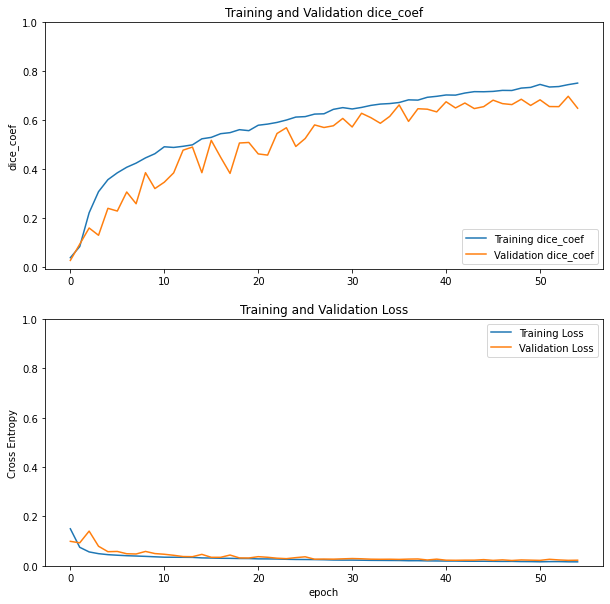

In [ ]:
dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(dice_coef, label='Training dice_coef')
plt.plot(val_dice_coef, label='Validation dice_coef')
plt.legend(loc='lower right')
plt.ylabel('dice_coef')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation dice_coef')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Showing our predicted masks on our test data

5/5 [==============================] - 15s 2s/step


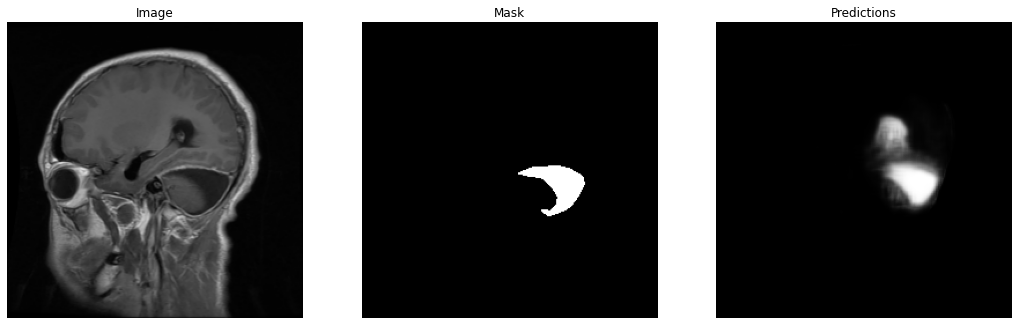

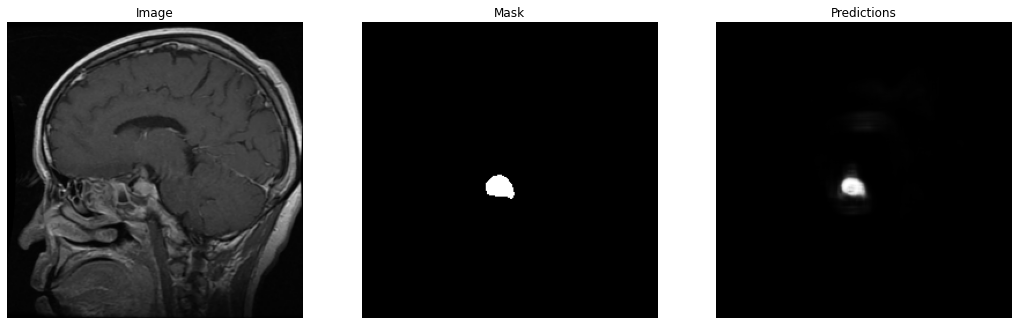

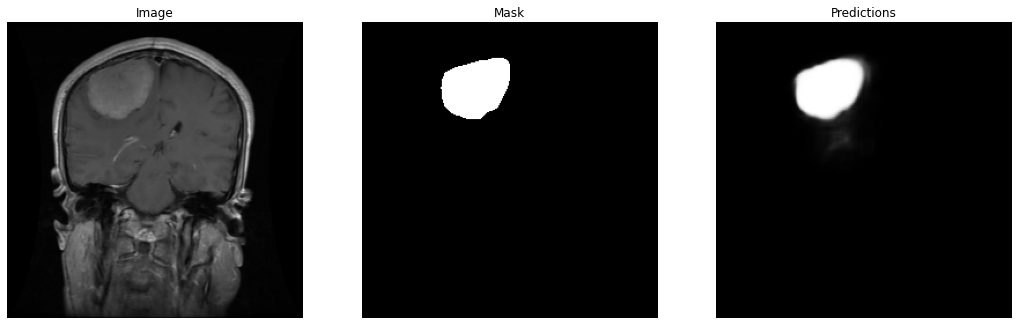

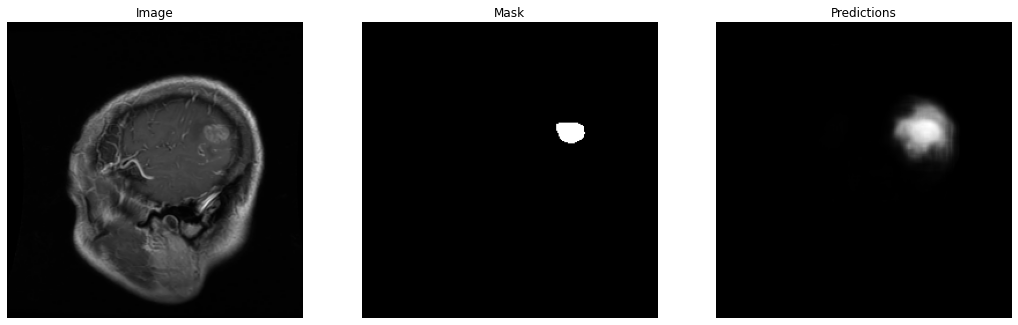

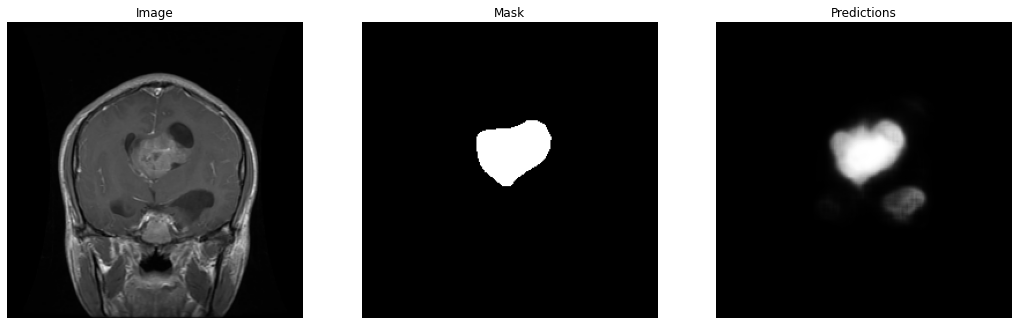

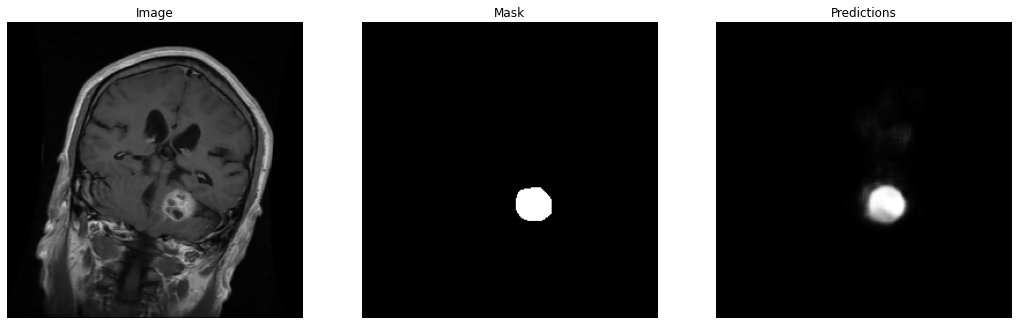

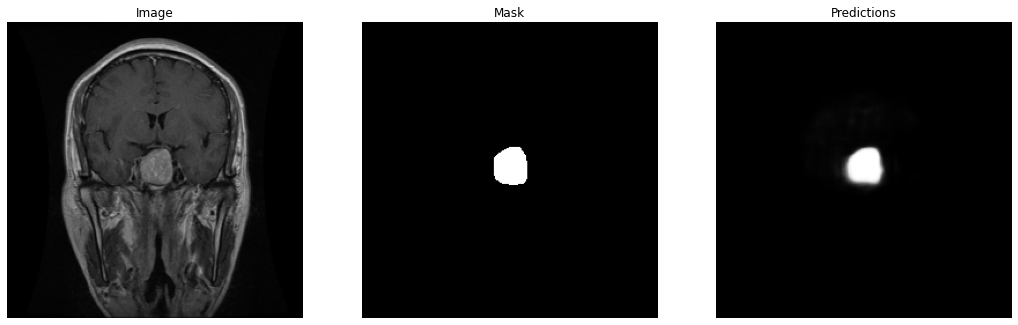

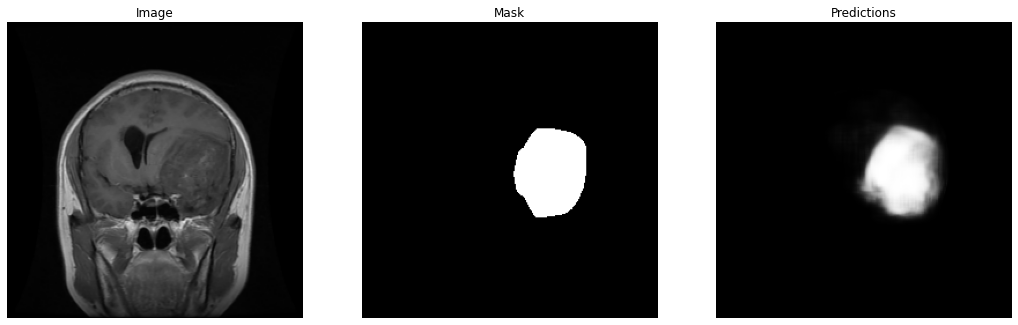

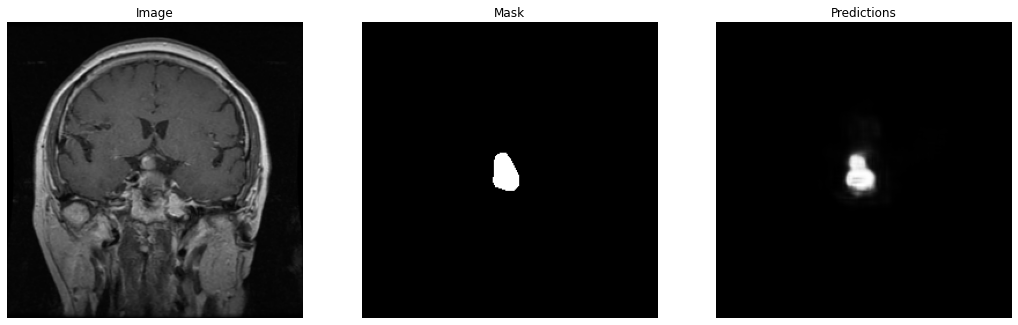

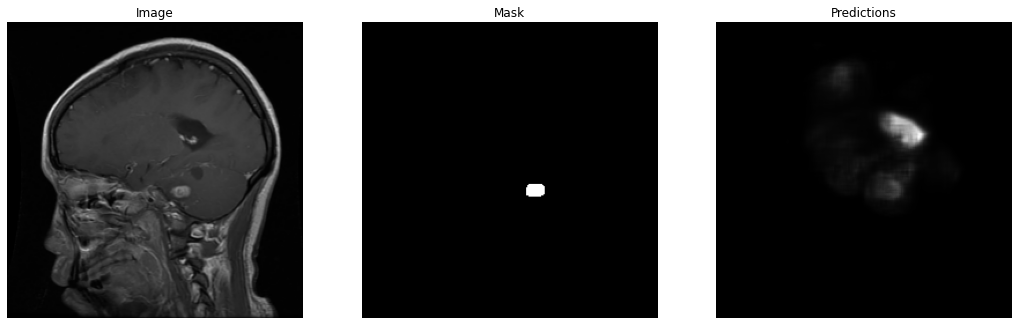

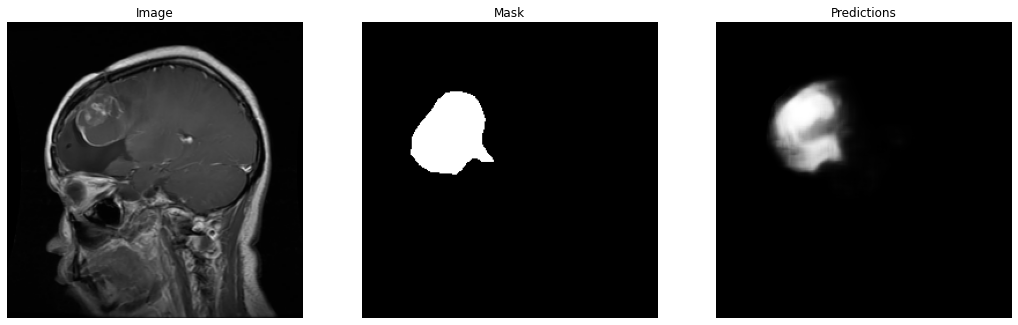

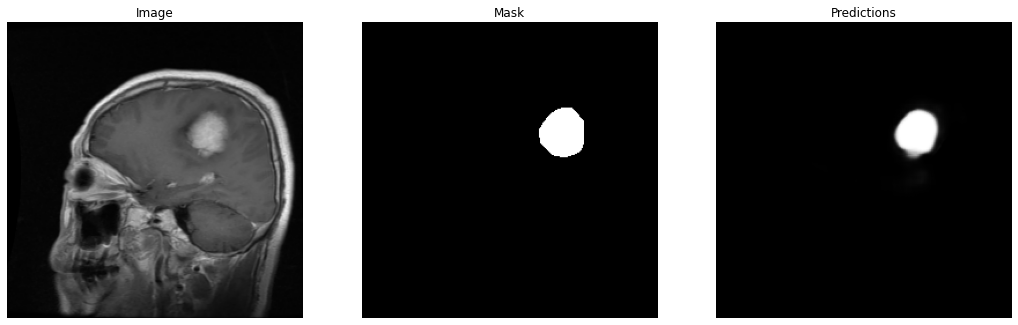

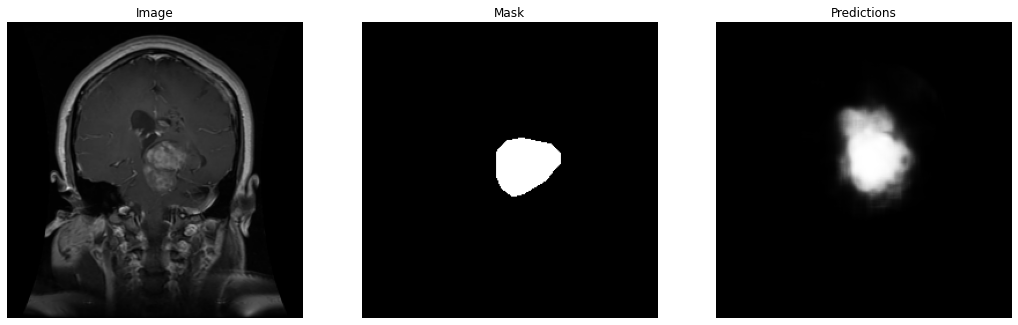

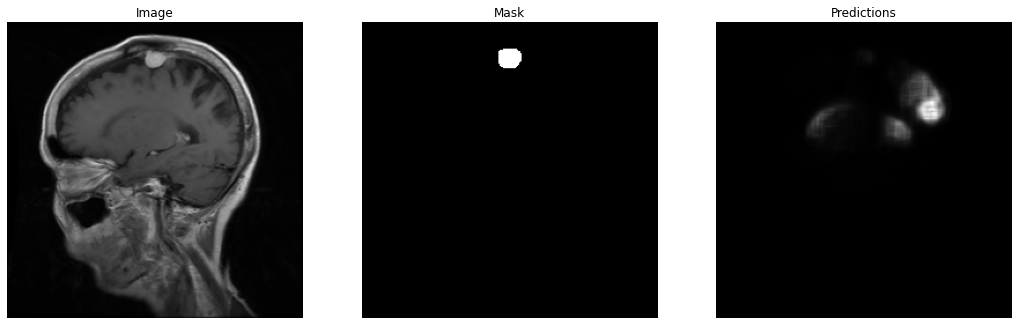

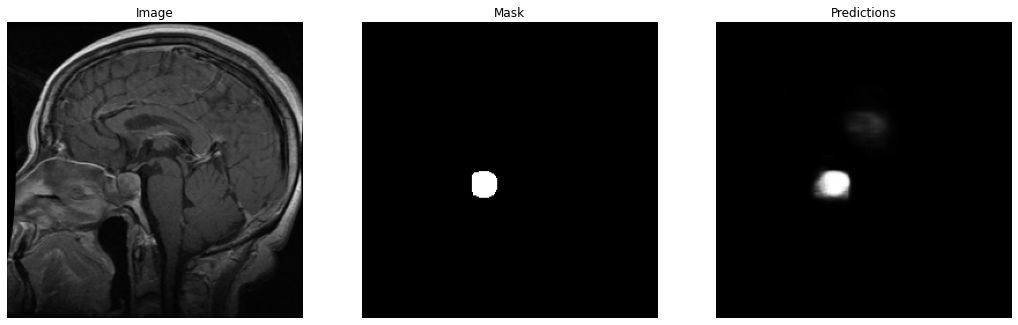

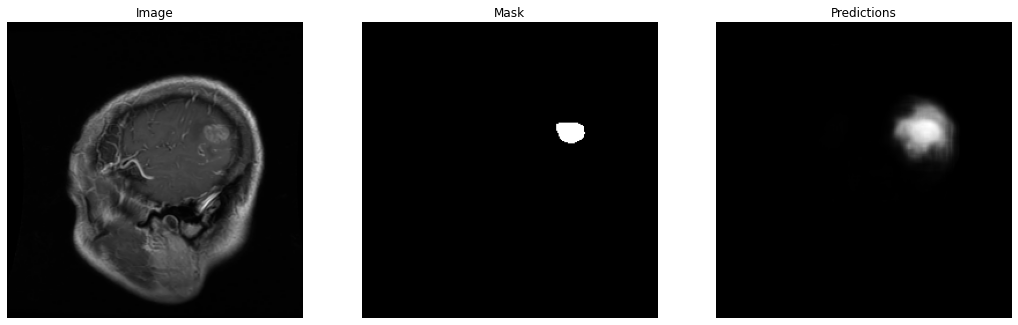

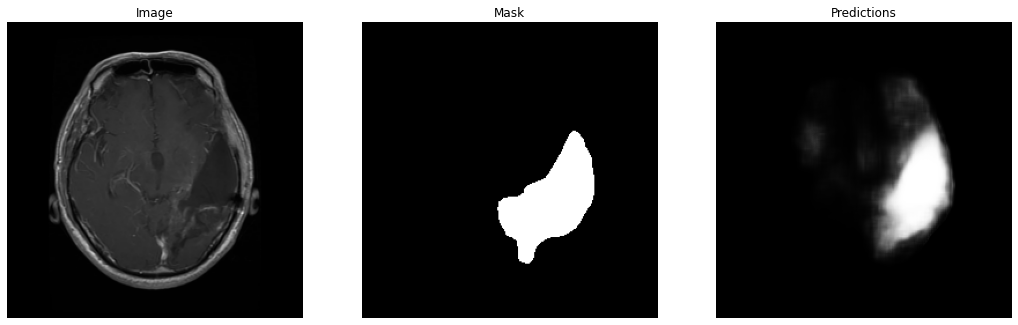

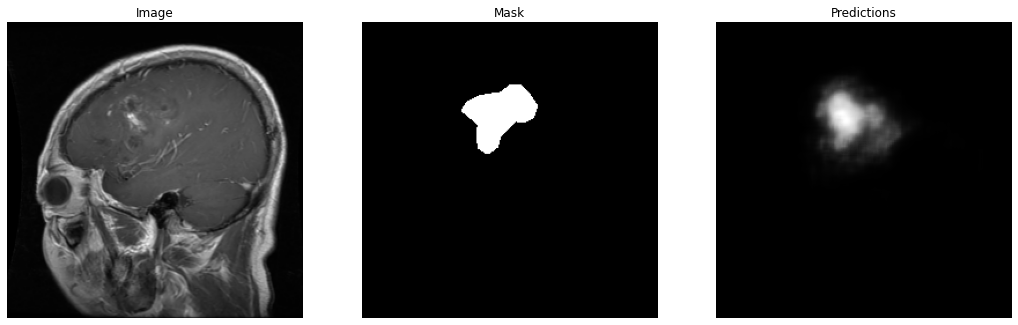

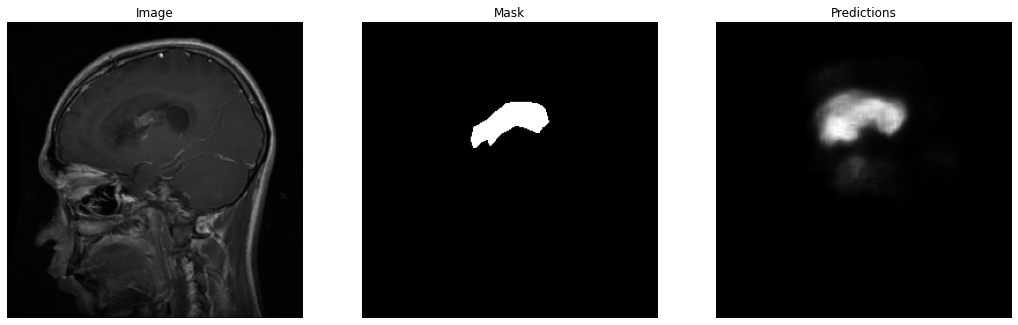

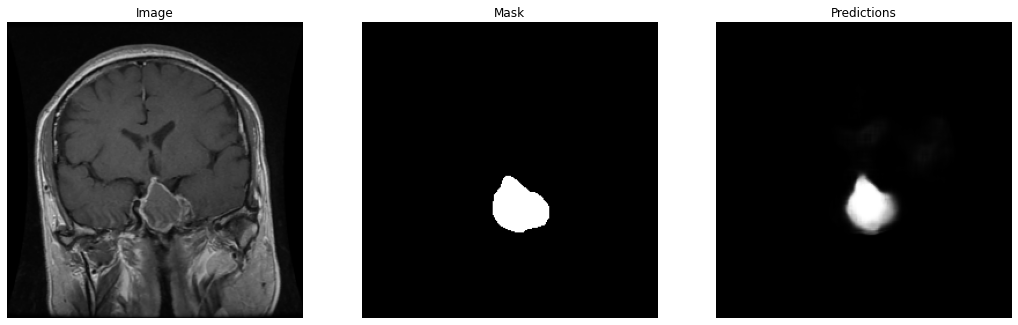

In [ ]:
# Ploting our predicted masks
import random

preds_test = model.predict(X_test, verbose=1)
for n in range(20):
    ix = random.randint(0, len(preds_test))
    plt.figure(figsize=(18,18))

    # Our original test image
    plt.subplot(131)
    plt.imshow(X_test[ix])
    plt.axis('off')
    plt.title("Image")

    # Our original mask  
    plt.subplot(132)
    plt.imshow(np.squeeze(Y_test[ix]), cmap="gray")
    plt.axis('off')
    plt.title("Mask")

    # The mask our LDNet model predicts
    plt.subplot(133)
    plt.imshow(np.squeeze(preds_test[ix]), cmap="gray")
    plt.axis('off')
    plt.title("Predictions")
    plt.show()